<a href="https://colab.research.google.com/github/KoNGoL/tfm_breast_cancer_detection/blob/main/Pruebas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install pydicom
!pip install opencv-python
!pip install pillow # optional 
!pip install pandas 

     |████████████████████████████████| 2.0 MB 2.9 MB/s eta 0:00:01


In [4]:
#imports
import matplotlib.pyplot as plt
import pydicom as dicom
import os
# from google.colab.patches import cv2_imshow as cv2
import cv2 as cv2
import PIL # optional

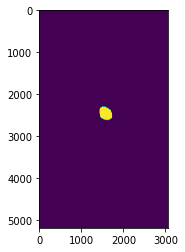

In [27]:
#convertir diccom a png
in_path = "/content/drive/MyDrive/TFM/Pruebas/originales/"
out_path = "/content/drive/MyDrive/TFM/Pruebas/procesadas/"
name = "man2.dcm"
out_name = name+ ".png"
def convert_diccom_to_png(in_file, out_path):
  ds = dicom.dcmread(os.path.join(in_path, name))
  pixel_array_numpy = ds.pixel_array
  cv2.imwrite(os.path.join(out_path, out_name), pixel_array_numpy)

image_path = in_path + "man2_mask2.dcm"
def show_diccom_img(diccom_path):
  ds = dicom.dcmread(image_path)
  plt.imshow(ds.pixel_array)
  plt.show()


convert_diccom_to_png(in_path + name, out_path + out_name)
show_diccom_img(in_path + name)

In [36]:
# recortar imagen
image_path = out_path + "man2.dcm.png"
img = cv2.imread(image_path)
print(img.shape)
y_start = int(img.shape[0]/96)
y_end = img.shape[0] - y_start
x_start = int(img.shape[1]/100)
x_end = img.shape[1] - x_start

crop_img = img[y_start:y_end, x_start:x_end]
cv2.imshow("cropped", crop_img)
cv2.waitKey(0)

AttributeError: ignored